In [1]:
from adjustText import adjust_text

In [2]:
import pandas as pd
import numpy as np
import heartpy as hp
from   matplotlib import pyplot as plt
import tsfel
import scipy 
import sklearn as sk
from   sklearn.ensemble import RandomForestRegressor
import librosa
import csv
import pandas as pd
import os
import xgboost as xgb
import random
import statsmodels.regression
from   warnings import filterwarnings
import lightgbm as ltb
from   sklearn import metrics
import catboost as cab
from   sklearn.model_selection import GridSearchCV
import time
from   datetime import datetime
from   sklearn.metrics import mean_squared_error, accuracy_score
from   sklearn.metrics import r2_score
from   IPython.display import clear_output
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve

In [3]:
def bland_altman_plot(data1, data2):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff,   c = 'black')
    plt.axhline(md,           color='green', linestyle='--')
    plt.axhline(md + 1.96*sd, color='red',   linestyle='--')
    plt.axhline(md - 1.96*sd, color='red',   linestyle='--')
    plt.xlabel("Average of the two measures", fontsize = 14)
    plt.ylabel("Difference between the two measures", fontsize = 14)
    plt.title("Bland-Altman plot for estimated %HbA1c values", fontsize = 14)
    # plt.savefig('./Figure/RF_trans_BA_Plot.png', bbox_inches = "tight", transparent = True, dpi = 400)

In [4]:
from matplotlib.patches import Circle, Wedge, Polygon, Path
from matplotlib.collections import PatchCollection

def error_grid_analysis(ref,est):
    fig, ax = plt.subplots()

    polygons = []

    A  = [[4.0,4.0],[5.7,4.0],[5.7,5.4],[7.2,6.5],[12.0,6.5],[12.0,12.0],[6.5,12.0],[6.5,7.2],[5.4,5.7],[4.0,5.7]]
    Bd = [[5.7,4.0],[5.7,5.4],[7.2,6.5],[12.0,6.5],[12.0,5.7],[6.5,5.7],[6.5,4.0]]
    Bu = [[4.0,5.7],[5.4,5.7],[6.5,7.2],[6.5,12.0],[5.7,12.0],[5.7,6.5],[4.0,6.5]]
    Cd = [[6.5,4.0],[6.5,5.7],[12.0,5.7],[12.0,4.0]]
    Cu = [[4.0,6.5],[5.7,6.5],[5.7,12.0],[4.0,12.0]]

    # print(np.asarray(A).shape)
    pA  = Polygon(np.asarray(A))
    pBd = Polygon(np.asarray(Bd))
    pBu = Polygon(np.asarray(Bu))
    pCd = Polygon(np.asarray(Cd))
    pCu = Polygon(np.asarray(Cu))

    polygons.append(pA)
    polygons.append(pBd)
    polygons.append(pBu)
    polygons.append(pCd)
    polygons.append(pCu)


    p = PatchCollection(polygons)
    p.set_color([[0,1,0,0.3],[1,1,0,0.3],[1,1,0,0.3],[1,0,0,0.3],[1,0,0,0.3]])
    ax.add_collection(p)



    plt.plot([4.0,12.0],[4.0,12.0])


    x = ref
    y = est

    sA = []
    sB = []
    sC = []
    for i in range(len(y)):
        sA.append(int(pA.contains_point ([x[i],y[i]]))*30)
        sB.append(int(pBd.contains_point([x[i],y[i]]) or pBu.contains_point([x[i],y[i]]))*30)
        sC.append(int(pCd.contains_point([x[i],y[i]]) or pCu.contains_point([x[i],y[i]]))*30)


    plt.scatter(x,y,s=sA,color=[0.227, 0.513, 0.282,1])
    plt.scatter(x,y,s=sB,color=[0.886, 0.654, 0.133,1])
    plt.scatter(x,y,s=sC,color=[0.941, 0, 0.098,1])

    lx = np.linspace(min(x), max(x), 100)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(lx,p(lx))


    plt.text(10.5,9,'A',fontsize=26)
    plt.text(9,10.5,'A',fontsize=26)
    plt.text(10.5,5.94,'B',fontsize=26)
    plt.text(5.94,10.5,'B',fontsize=26)
    plt.text(10.5,4.7,'C',fontsize=26)
    plt.text(4.7,10.5,'C',fontsize=26)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.xlim([4.0,12.0])
    plt.ylim([4.0,12.0])
    plt.xlabel('HbA1c Invasive device (%NGSP)',fontsize=15)
    plt.ylabel('HbA1c Estimated (%NGSP)',fontsize=15)
    plt.title('Error Grid Analysis (EGA) for estimated %HbA1c values',fontsize=15)
    plt.show()

In [5]:
    
def hBAA(ref,est,xp=7):
    texts = []
    x = []
    y = []
    for i in range(len(ref)):
        m = est[i]
        o = ref[i]
        x.append((o+m)/2)
        y.append(o-m)

    plt.figure()
    plt.hlines(0.00,np.amin(x),np.amax(x),linestyles='solid')
    plt.hlines(np.mean(y)+1.96*np.std(y),np.amin(x),np.amax(x),linestyles='dotted')
    plt.hlines(np.mean(y)-1.96*np.std(y),np.amin(x),np.amax(x),linestyles='dotted')
    plt.hlines(np.mean(y),np.amin(x),np.amax(x),linestyles='dashdot')

    print('Mean: ',np.mean(y))
    print('+1.96 STD: ',np.mean(y)+1.96*np.std(y))
    print('-1.96 STD: ',np.mean(y)-1.96*np.std(y))
    print('Bias: ',np.mean(y),'+-',np.std(y))

    texts.append(plt.text(xp,np.mean(y)+1.96*np.std(y),'Mean+1.96 STD = %0.2f' % (np.mean(y)+1.96*np.std(y))))
#     texts.append(plt.text(xp,np.mean(y)+1.96*np.std(y),'%0.2f' % (np.mean(y)+1.96*np.std(y))))
    texts.append(plt.text(xp,np.mean(y)-1.96*np.std(y),'Mean-1.96 STD = %0.2f' % (np.mean(y)-1.96*np.std(y))))
#     texts.append(plt.text(xp,np.mean(y)-1.96*np.std(y),'%0.2f' % (np.mean(y)-1.96*np.std(y))))
    texts.append(plt.text(xp,np.mean(y),'Mean = '+ '%.2f' % np.mean(y)))

    plt.scatter(x,y)

    plt.xlabel('(Ref HbA1c + DVP HbA1c)/2 (%)',fontsize=12)
    plt.ylabel('Ref HbA1c - DVP HbA1c (%)',fontsize=12)
    plt.title('Bland Altman analysis of %NGSP HbA1c estimations',fontsize=12)
    print('\n')
    adjust_text(texts,only_move={'points':'y', 'text':'y'})

In [6]:
a= [5.455971819963604,
 5.710776244515303,
 6.224456061972863,
 5.63141826055283,
 6.133840708939875,
 5.605366210161767,
 5.685988435852813,
 7.192537033965046,
 5.624162154847344,
 7.117127356371105,
 5.673273191370337,
 5.586100983940301,
 5.597247390001206,
 7.403396353983958,
 5.2610962685245575,
 5.696019244662147,
 5.486863210091453,
 6.039997727763002,
 5.740995959097452,
 5.71155225809985]

In [7]:
b=[5.200000000000002,
 5.5,
 5.700000000000003,
 5.6,
 5.799999999999998,
 5.700000000000003,
 5.200000000000001,
 7.6000000000000005,
 6.0,
 7.400000000000001,
 5.799999999999999,
 5.9,
 6.0,
 7.700000000000002,
 5.399999999999999,
 5.600000000000001,
 5.3,
 5.5,
 5.600000000000001,
 6.5]

Mean:  0.021090656266159823
+1.96 STD:  0.7115999196744156
-1.96 STD:  -0.669418607142096
Bias:  0.021090656266159823 +- 0.3523006445960489




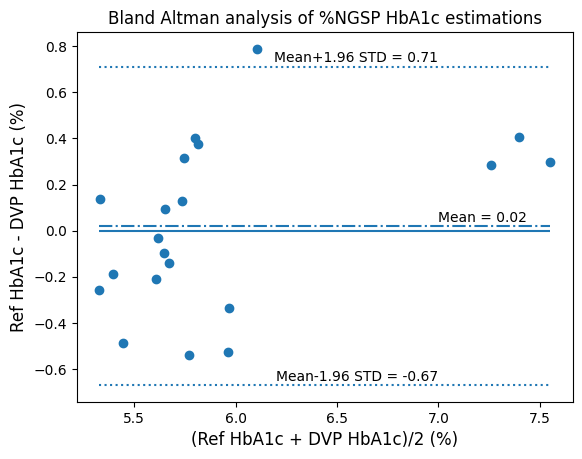

In [8]:
hBAA( b, a)